# Time Series Analysis

San Francisco International Airport (IATA code: SFO) is located south of San Francisco downtown and it’s a very important air transportation hub for both domestic and international flights. 

It is equipped with four asphalt runways – two perpendicular pairs. 

This airport is one of the main hubs for the United Airline which generates relatively a big chunk of airport's traffic.

It is also worth to check airport's annual report to learn more about the operational side of the airport: https://s3.amazonaws.com/media.flysfo.com/2017_Annual_Report.pdf

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # data visualisation
import datetime as dt # working with time data
import warnings  
warnings.filterwarnings('ignore')

In [4]:
PAX_raw = pd.read_csv("./data/air_traffic/air-traffic-passenger-statistics.csv")
PAX = PAX_raw.copy()
PAX.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


In [5]:
PAX.loc[:,"Activity Period"] = pd.to_datetime(PAX.loc[:,"Activity Period"].astype(str), format="%Y%m")
PAX.loc[:,"Year"] = PAX["Activity Period"].dt.year
PAX.loc[:,"Month"] = PAX["Activity Period"].dt.month

In [6]:
time_begin = PAX.loc[:,"Activity Period"].min()
time_end = PAX.loc[:,"Activity Period"].max()
time_range = time_end-time_begin

print("First date: ", str(time_begin)[:11])
print("Last date: ", str(time_end)[:11])
print("Time range in days:", time_range.days)
print("Time range in months:", time_range/np.timedelta64(1,"M"))

First date:  2005-07-01 
Last date:  2018-06-01 
Time range in days: 4718
Time range in months: 155.00934310766135


# SARIMAX Preparation

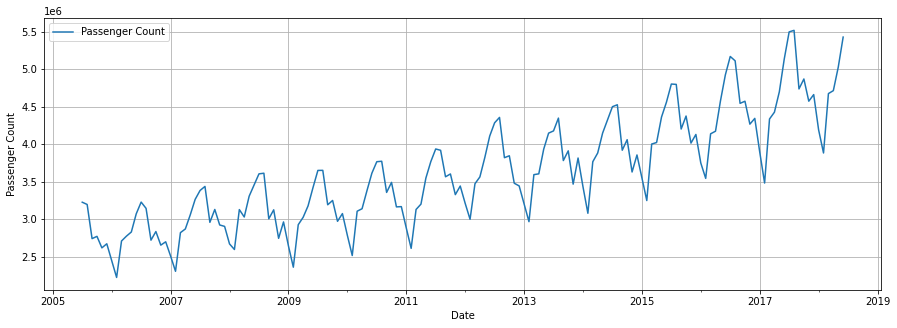

In [7]:
TS1 = PAX.groupby("Activity Period")["Passenger Count"].sum().to_frame()

f, ax1 = plt.subplots(1,1,figsize=(15,5))
TS1.plot(ax=ax1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Passenger Count")
plt.grid(True)

The Augmented Dickey-Fuller test can be used to test for stationarity of our time series. The null hypothesis of the test is that the time series is not stationary (has some time-dependent structure).

- Null Hypothesis (H0): if failed to be rejected (high p-value) means it is non-stationary
- Null Hypothesis (H1): if H0 is rejected (low p-value) means it is stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(TS1["Passenger Count"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: 1.133106
p-value: 0.995489


No surprise. P-value is 0.99 (we don't reject H0) - time series is not stationary.

To better understand the time series behaviour I will decompose it into trend, seasonality and residuals.

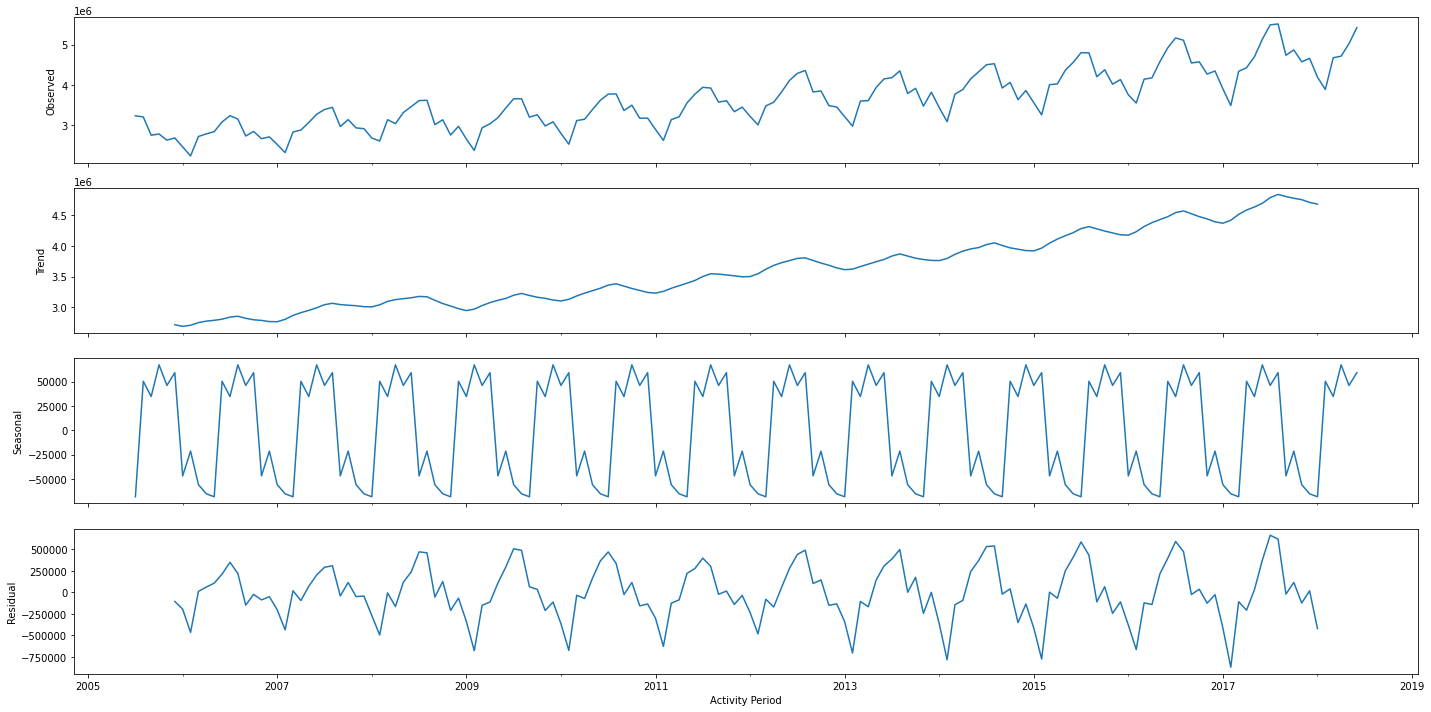

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(TS1, model="additive",freq=10)
add = decomposed_add.plot()
plt.show()

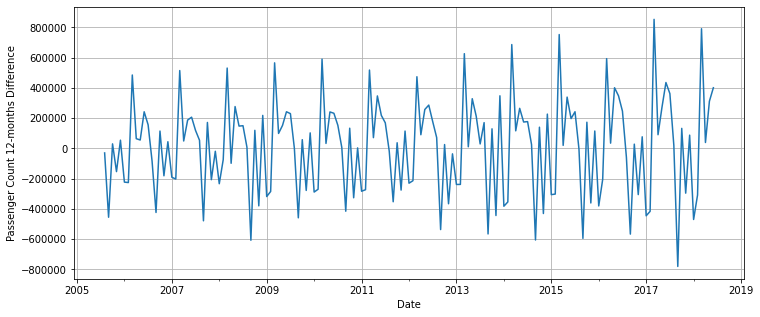

In [8]:
TS1_diff = TS1.diff().dropna()
plt.figure(figsize=(12,5))
ax1 = TS1_diff["Passenger Count"].plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Passenger Count 12-months Difference")
plt.grid(True)
plt.show()

In [18]:
results = adfuller(TS1_diff["Passenger Count"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -2.950493
P-value of a test is: 0.03978361480384744


The p-value of 0.0397 is small enough to reject the null hipothesis that the time series is non-stationary. However, the plot above shows still a seasonality.

Let's see what would be result of the same test is we take a second difference. Pleas note that you have to be aware of risk of so called overdifferencing time series.

In [19]:
results = adfuller(TS1.diff().diff().dropna()["Passenger Count"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -5.647791
P-value of a test is: 1.0020534478924393e-06


Indeed the p-value test dropped even more. However, often the simplest solutions work the best - therefore I will stay with a simple single difference.

AutoCorrelation Plot (ACF) shows a correlation between "a signal" (our value) with its delayed occurance (observation) in a function of time delta between them (so called lag).  
Partial AutoCorrelation Plot (PCAF) is similar to ACF but the effect of the shorter lags is removed.

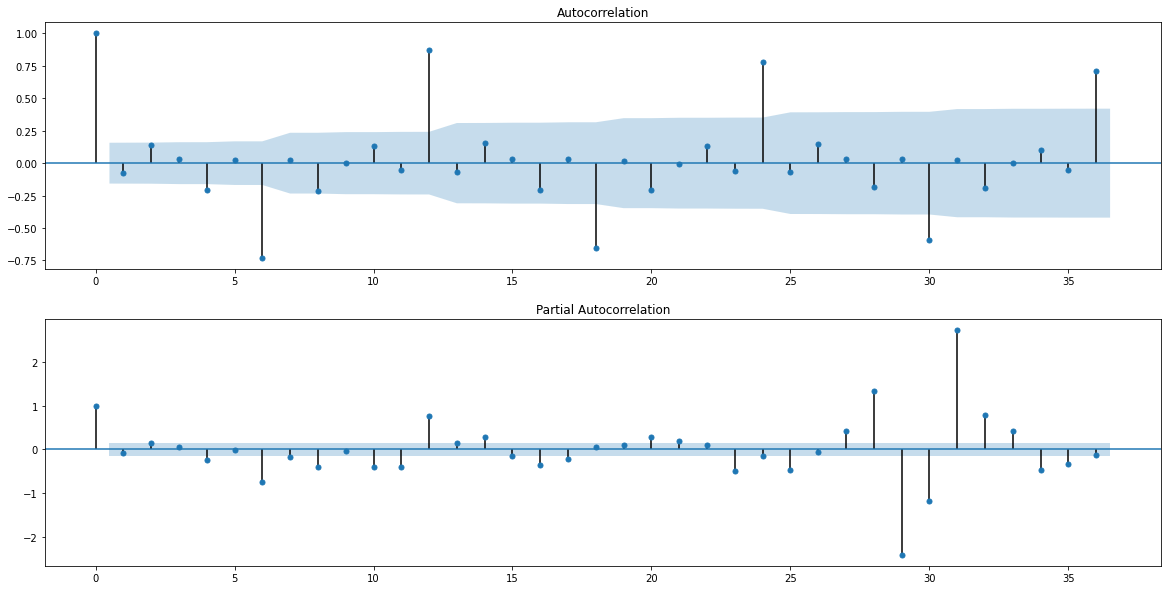

In [20]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(TS1_diff, lags=36, ax=ax[0])
plot_pacf(TS1_diff, lags=36, ax=ax[1])
plt.show()

The lag plot below allows to check a lag correlation. If you can identify a structure in the plot, the data doesn't look random and the autocorrelation is indeed present. In this case I will check the lag plot for lags of 1 and 2 months.

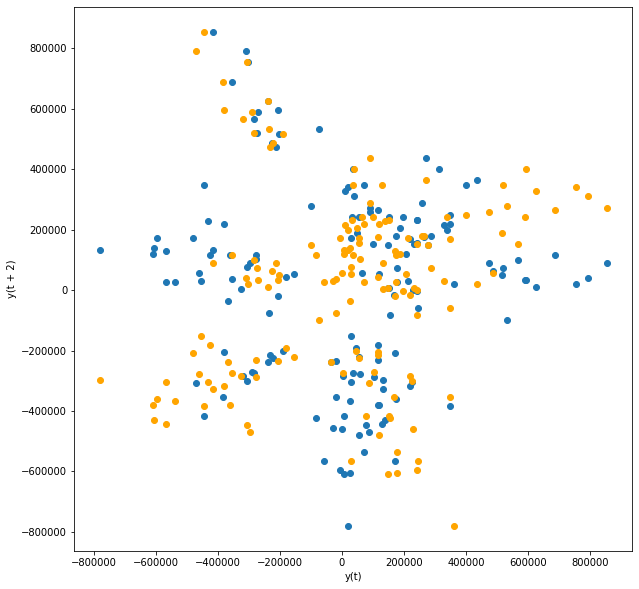

In [21]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(figsize=(10, 10))
ax = lag_plot(TS1_diff, lag=1)
ax = lag_plot(TS1_diff, lag=2, c="orange")

plt.show()

In the next step we will iterate over p and q parameters of ARIMA model and compute for each Akaike Information Critera (AIC) and Bayesian Information Criteria (BIC). BIC is giving additional penalty for more parameters.

In [22]:
from statsmodels.tsa.arima_model import ARIMA

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(TS1.astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="sum_aic_bic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic
9,2,1,4371.03,4386.24,8757.27
12,3,0,4370.65,4385.87,8756.52
5,1,1,4371.36,4383.53,8754.89
6,1,2,4369.07,4384.29,8753.36
8,2,0,4369.14,4381.31,8750.44
1,0,1,4370.23,4379.36,8749.58
4,1,0,4370.01,4379.14,8749.16
2,0,2,4368,4380.18,8748.18
0,0,0,4368.99,4375.08,8744.07
3,0,3,4360.71,4375.93,8736.64


Let's look now at SARIMAX(2,1,1)x(0,1,0,12) diagnostics summary and diagnostics plots.

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(TS1, order=(2,1,1), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                    Passenger Count   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1842.014
Date:                            Fri, 15 May 2020   AIC                           3692.028
Time:                                    10:02:07   BIC                           3703.879
Sample:                                07-01-2005   HQIC                          3696.844
                                     - 06-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9479      0.025     38.079      0.000       0.899       0.997
ar.L2          0.0096      0.024      0.393      0.694      -0.038       0.057
ma.L1         -0.9998      0.092    -10.893      0.000      -1.180      -0.820
sigma2      8.149e+09   1.13e-11   7.23e+20      0.000    8.15e+09    8.15e+09
===================================================================================
Ljung-Box (Q):                      110.97   Jarque-Bera (JB):                 8.76
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.04   Skew:                             0.32
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.16e+35. Standard errors may be unstable.
"""

Summary explanations:

- Ljung-Box (Q) - This test is used to check for the lack of fit of a time series model. The null hypothesis here is there are no correlations in the residuals. In our case we reject the null hypothesis what means that residuals are somehow correlated.

- Jarque-Bera (JB) - This is a test for normality of distributon. It is basing on values of skewness and kurtosis where for the normal distibution these values should be respectively 0 and 3. The null hypothesis of the test is that the sample comes from the normal distribution. Ander this hypothesis the chi-squared distribution with 2 degrees of freedom can be used. In our case JB statistics is 8.76 which gives probability of 0.01 - meaning that we don't reject the null hypothesis.

- Heteroskedasticity (H) - Checks if the variance is constant

When looking at the diagnostic plots below we are interested in:

- Standardized residual - there are no obvious patterns in the residuals
- Histogram plus kde estimate - KDE should be very similar to the normal distribution
- Normal Q-Q - points should lie on the straight line
- Correlogram - 95% of correlations for lag greater than one should not be significant

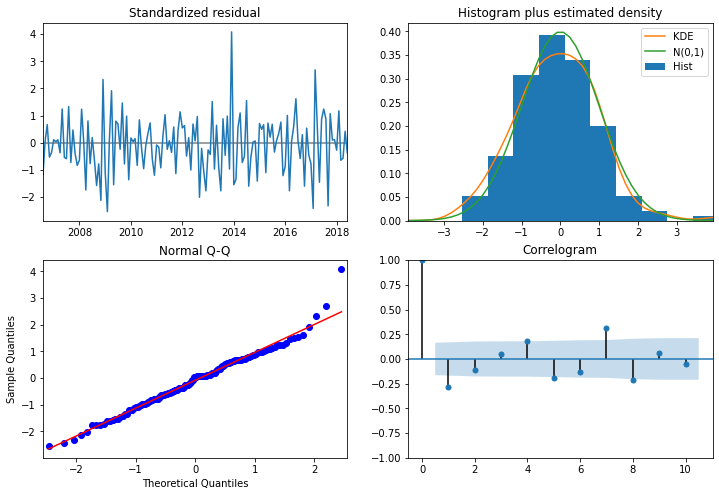

In [24]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

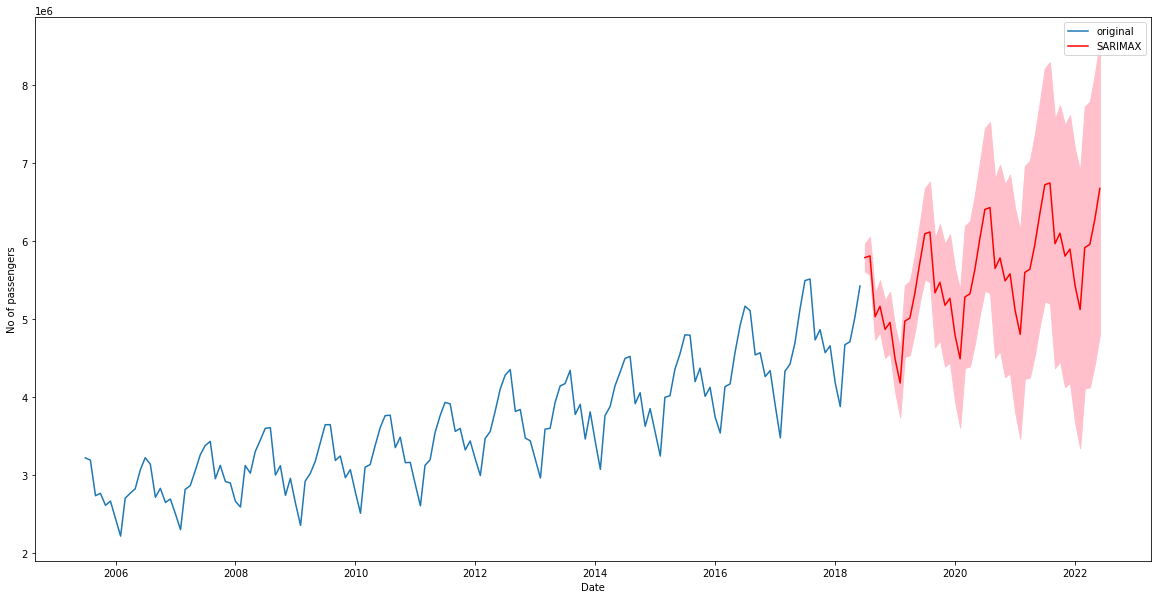

In [25]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=48)
lower = forecast.conf_int()["lower Passenger Count"]
upper = forecast.conf_int()["upper Passenger Count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(TS1, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.fill_between(forecast.conf_int().index, 
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

The plot above shows predictions using SARIMAX(2,1,1)x(0,1,0,12). The red line indicates the mean and the pink area is bounded by 95% confidence intervals. According to this prediction in 2022 a number of passengers can reach 8 millions at the peak time.

--------------

# Machine Learning Forecast

In this secion we will focus on the Machine Learning approach to forecasting time series. First we will prepare our data - input(X) and output(y) variables.

In [9]:
from sklearn.svm import SVR, SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def tsplit(X,y,model):
    tscv = TimeSeriesSplit(n_splits=3)
    fig,ax = plt.subplots(3, figsize=(15,8))
    axis = 0
    for train_index, test_index in tscv.split(X):
        #splitting data into training and test sets
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
        #fitting model
        model.fit(X_train,y_train.values.ravel())
        #predicting
        predictions = model.predict(X_test)
        #printing results
        print("MSE for split {0}:".format(axis+1))
        print(mean_squared_error(y_test,predictions))
        #ax[axis].plot(X_train.index, y_train) # needs fixing
        ax[axis].plot(list(X_test.index), predictions)
        ax[axis].plot(list(X_test.index), y_test)
        axis += 1
    return(None)

In [10]:
TS1["Year"] = TS1.index.year
TS1["Month"] = TS1.index.month
TS1.head()
X = TS1[["Year","Month"]]
y = TS1[["Passenger Count"]]

Let's look at the data again...

No handles with labels found to put in legend.


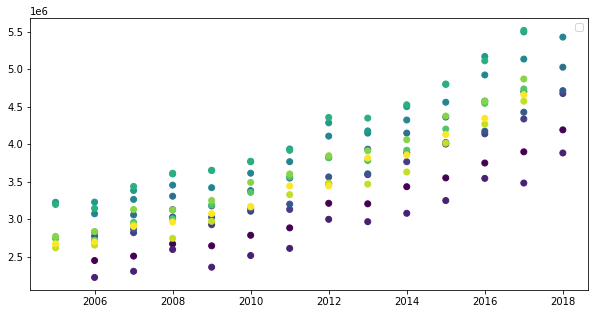

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(TS1["Year"],TS1["Passenger Count"],c=TS1["Month"])
plt.legend()
plt.show()

No handles with labels found to put in legend.


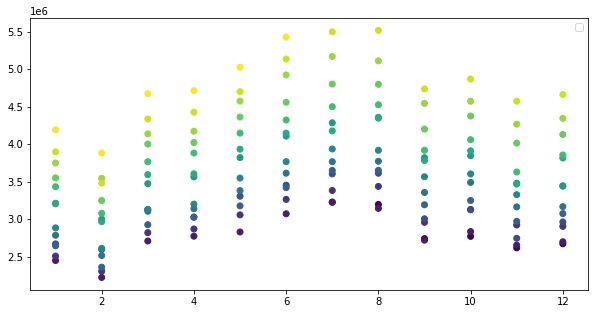

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(TS1["Month"],TS1["Passenger Count"],c=TS1["Year"])
plt.legend()
plt.show()

They are non-stationary what will cause problems as in SARIMAX approach.

In [13]:
X2 = TS1[["Year","Month"]][1:]
y2 = np.log(TS1[["Passenger Count"]]).diff().dropna()
X2.head()

,Year,Month
Activity Period,,
2005-08-01,2005,8
2005-09-01,2005,9
2005-10-01,2005,10
2005-11-01,2005,11
2005-12-01,2005,12


Data for machine learning should be scaled.

Scaling data with standard scaler.

In [14]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
# Scale x and y (two scale objects)
X2_scaled = pd.DataFrame(sc_x.fit_transform(X2))
y2_scaled = pd.DataFrame(sc_y.fit_transform(y2))

### Ridge Regression

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [16]:
rdg = KernelRidge(kernel='rbf')
parameters = {'alpha':np.arange(0.005,0.02,0.005), 'gamma':np.arange(0.001,0.01,0.001)}

tscv = TimeSeriesSplit(n_splits=3)
rdg_gs = GridSearchCV(rdg, parameters, cv=tscv, verbose=0, scoring='neg_mean_squared_error')
rdg_gs.fit(X2_scaled, y2_scaled)

rdg_gs.best_score_
best_rdg = rdg_gs.best_estimator_
print(best_rdg)

KernelRidge(alpha=0.005, coef0=1, degree=3, gamma=0.009000000000000001,
      kernel='rbf', kernel_params=None)


MSE for split 1:
0.9775684416976811
MSE for split 2:
0.9955735692132949
MSE for split 3:
0.7911106962196345


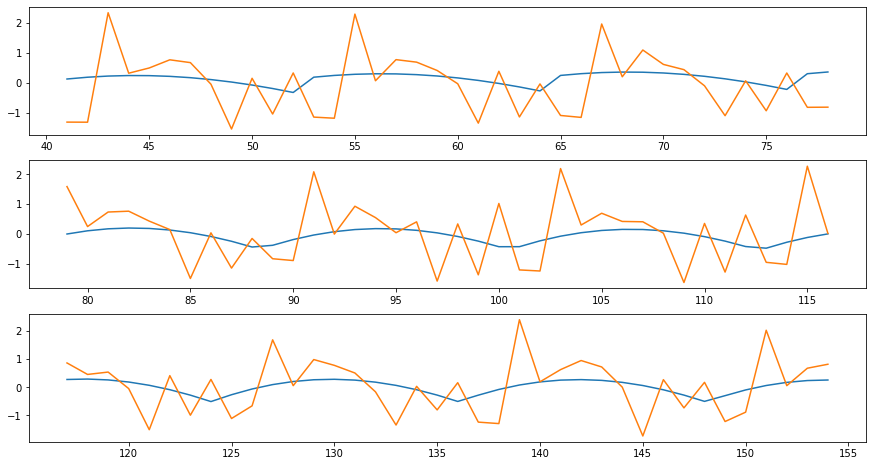

In [17]:
tsplit(X2_scaled,y2_scaled,best_rdg)

### SVR Prediction

In [18]:
svr = SVR()
parameters = {'kernel':['rbf','poly'],
              'C':np.arange(0.2,0.8,0.1),
              'gamma':np.arange(0.2,1.2,0.02),
              'degree':[3,4,5]}

tscv = TimeSeriesSplit(n_splits=3)
reg = GridSearchCV(svr, parameters, cv=tscv, verbose=0, scoring='neg_mean_squared_error')
reg.fit(X2_scaled, y2_scaled.values.ravel())

reg.best_score_
best_svr = reg.best_estimator_
print(best_svr)

SVR(C=0.8000000000000003, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.41999999999999993, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


MSE for split 1:
0.7208965208806775
MSE for split 2:
0.9043619860055825
MSE for split 3:
0.8128092414456066


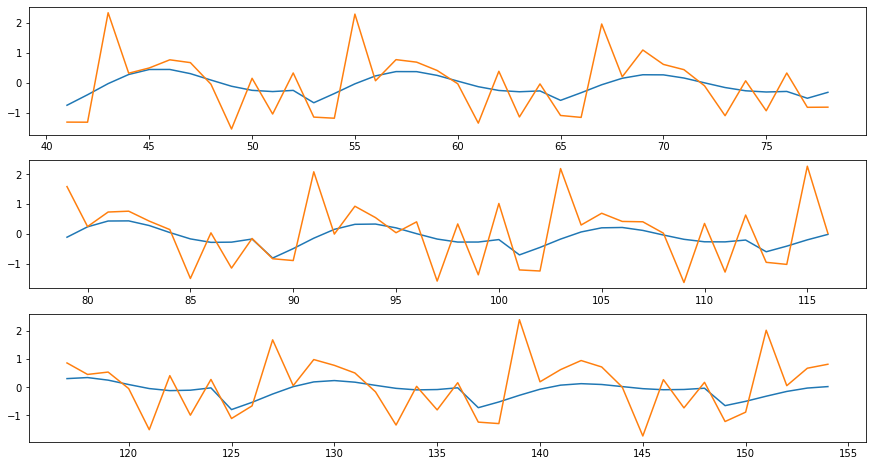

In [19]:
tsplit(X2_scaled,y2_scaled,best_svr)

### Regressor

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

mlp = MLPRegressor(max_iter=600)
parameters = {'hidden_layer_sizes':np.arange(800,1400,50),'alpha':[0.0001,0.0002], 'momentum':[0.85,0.9,0.95]}

tscv = TimeSeriesSplit(n_splits=3)
reg = GridSearchCV(mlp, parameters, cv=tscv, verbose=0, scoring='neg_mean_squared_error')
reg.fit(X2_scaled, y2_scaled.values.ravel())

reg.best_score_
best_mlp = reg.best_estimator_
print(best_mlp)

MSE for split 1:
0.5099875050847021
MSE for split 2:
0.45580877694386585
MSE for split 3:
0.34047765160672633


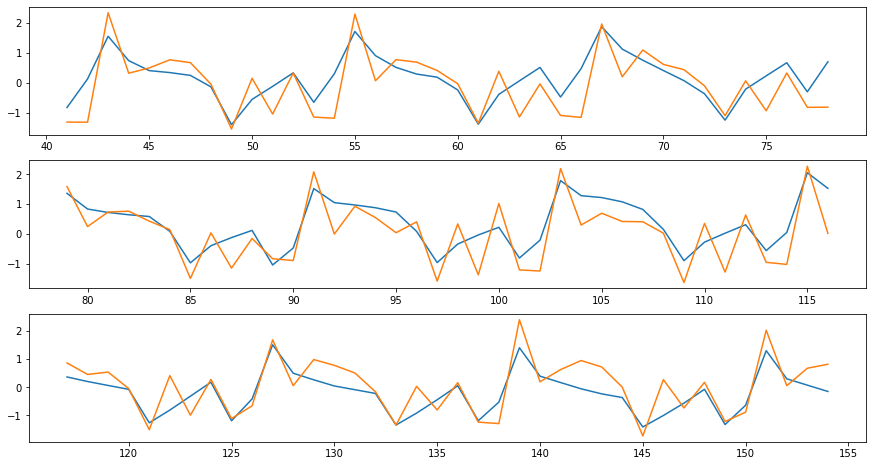

In [39]:
tsplit(X2_scaled,y2_scaled,best_mlp)